# Evaluación de curso Analítica Predictiva
---
Juan Carlos Fiallos

En esta tarea se evalúa la habilidad para construir modelos de clasificación siguiendo la metodología CRISP-DM. Para ello, se seleccionó el dataset Credit Approval proveniente del repositorio de datos del UCI, de la categoría Business, en la siguiente dirección: (https://archive.ics.uci.edu/ml/datasets/Credit+Approval).


## Definición del problema desde el punto de vista del negocio

Los datos corresponden a las solicitudes de los clientes para la aprobación de tarjetas de crédito, en una empresa determinada, a partir de atributos correspondientes a cada cliente. El análisis se realiza sobre la decisión de aprobar o negar la entrega de una tarjeta de crédito.


## Definición del problema con base en los datos

Se tiene una muestra que consta de 690 observaciones de aplicaciones para obtener una tarjeta de crédito. Cada registro contiene 16 variables que corresponden a atributos de cada cliente. Por motivos de confidencialidad los nombres y valores fueron cambiados a simbolos sin significado. Para el presente análisis se ha tomado los nombres y valores utilizados en estudios similares (http://www.rpubs.com/kuhnrl30/CreditScreen), de los cuales se obtienen las siguientes variabes:

* Male: Si el aplicante es hombre (1, 0)
* Age: La edad de los aplicantes
* Debt: Monto de deuda que mantiene el aplicante
* Married: Estado marital (u, y, l, t) 
* BankCustomer: Tipo de ciente (g, p, gg)
* EducationLevel: Nivel educativo (c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff)
* Ethnicity: Etnia (v, h, bb, j, n, z, dd, ff, o)
* YearsEmployed: Años de empleo
* PriorDefault: Si ha inclumplido pagos anteriormente (1, 0)
* Employed: Si está empleado actualmente (1, 0)
* CreditScore: Calificación de crédito
* DriversLicense: Si tiene licencia de conducir (1, 0)
* Citizen: Tipo de ciudadanía (g, p, s)
* ZipCode: Código postal
* Income: Ingresos
* Approved: Si la solicitud ha sido aprobada (0, 1)
 
En términos de los datos, se desea pronosticar si una aplicacion es aprobada o rechazada (clase 1 o 0) a partir de las 16 variables.

## Configuración inicial 

In [245]:
# Carga de librerias que serán utilizadas en el trabajo
library(rpart)
library(lattice)
library(ggplot2)
library(rpart.plot)
library(data.table)
library(caret)
library(doSNOW)
library(dplyr)
library(class)
library(MASS)
library(kernlab)  
library(pROC)
library(arules)
library(e1071)

In [246]:
################################################################################
# Paralelización
# Se utiliza la librería CARET para declarar los cluster y 
# mejorar los tiempos de entrenamiento de los modelos  
################################################################################

cl <- makeCluster(4, type = "SOCK") # se definie 4 cluster

registerDoSNOW(cl)# Registra los cluster para que caret pueda 
                  # entrenar en paralelo.

# Exploración

In [247]:
## Define el directorio de trabajo
setwd("C:/Users/juank/Documents/Doct/Clases/Data/")

## Define el tipo de columnas que va a leer
Cols<- c(rep("character",2), "numeric",rep("character",4),"numeric",rep("character",2), 
         "numeric",rep("character",3),"numeric","character")

## Lee el archivo
Data <- read.csv(file= "dataset.csv", sep = ",", colClasses=Cols, na.strings="?", head = F)

## Asigna nombres a las columnas
names(Data)<-c("Male","Age","Debt","Married","BankCustomer","EducationLevel",
               "Ethnicity", "YearsEmployed","PriorDefault","Employed","CreditScore",
               "DriversLicense","Citizen", "ZipCode","Income","Approved")

## Retira del ambiente al objeto Cols para liberar memoria  
rm(Cols)

## Verificación de los datos cargados
str(Data)

'data.frame':	690 obs. of  16 variables:
 $ Male          : chr  "b" "a" "a" "b" ...
 $ Age           : chr  "30.83" "58.67" "24.50" "27.83" ...
 $ Debt          : num  0 4.46 0.5 1.54 5.62 ...
 $ Married       : chr  "u" "u" "u" "u" ...
 $ BankCustomer  : chr  "g" "g" "g" "g" ...
 $ EducationLevel: chr  "w" "q" "q" "w" ...
 $ Ethnicity     : chr  "v" "h" "h" "v" ...
 $ YearsEmployed : num  1.25 3.04 1.5 3.75 1.71 ...
 $ PriorDefault  : chr  "t" "t" "t" "t" ...
 $ Employed      : chr  "t" "t" "f" "t" ...
 $ CreditScore   : num  1 6 0 5 0 0 0 0 0 0 ...
 $ DriversLicense: chr  "f" "f" "f" "t" ...
 $ Citizen       : chr  "g" "g" "g" "g" ...
 $ ZipCode       : chr  "00202" "00043" "00280" "00100" ...
 $ Income        : num  0 560 824 3 0 ...
 $ Approved      : chr  "+" "+" "+" "+" ...


In [248]:
# Preproceso de la data 

# Convierte los valores binarios a 0 o 1
Data$Male	 <- factor(ifelse(Data$Male=="a",1,0))
levels(Data$Male) <- c("M", "W")
Data$Employed	 <- factor(ifelse(Data$Employed=="t",1,0))
levels(Data$Employed) <- c("E", "NE")
Data$PriorDefault<- factor(ifelse(Data$PriorDefault=="t",1,0))
levels(Data$PriorDefaul) <- c("D", "ND")

##########################################################################
# La variable de respuesta es Data$Approved con valores de "R" Rechazada
# y "A" Aceptada la solicitud de tarjeta de crédito 
##########################################################################
Data$Approved	 <- factor(ifelse(Data$Approved=="+",1,0))
levels(Data$Approved) <- c("R", "A")


Data$Age<-as.numeric(Data$Age)

# Separa los campos numéricos para procesar independientemente
Numeric	<- Data[,c(2:3,8,11,15)]
summary(Numeric)

# Preproceso de variable edad (Age)
Mean.Age<- mean(Numeric$Age,na.rm=T) 
SD.Age	<-round(sd(Numeric$Age, na.rm=T),4)

# Uso la mayor correlación para predicir e imputar valores ausentes en la edad
round(cor(Numeric,use="complete.obs"),3)
AgeMdl<-lm(Age~YearsEmployed, data=Data,na.action=na.exclude)
AgeMdl$coefficients
Missing<-which(is.na(Data$Age))
Data$Age[Missing]<- predict(AgeMdl,newdata=Data[Missing,])

# Normaliza la variable edad
Data$AgeNorm<- (Data$Age-mean(Data$Age, na.rm=T))/SD.Age
rm(SD.Age, Mean.Age)

      Age             Debt        YearsEmployed     CreditScore  
 Min.   :13.75   Min.   : 0.000   Min.   : 0.000   Min.   : 0.0  
 1st Qu.:22.60   1st Qu.: 1.000   1st Qu.: 0.165   1st Qu.: 0.0  
 Median :28.46   Median : 2.750   Median : 1.000   Median : 0.0  
 Mean   :31.57   Mean   : 4.759   Mean   : 2.223   Mean   : 2.4  
 3rd Qu.:38.23   3rd Qu.: 7.207   3rd Qu.: 2.625   3rd Qu.: 3.0  
 Max.   :80.25   Max.   :28.000   Max.   :28.500   Max.   :67.0  
 NA's   :12                                                      
     Income        
 Min.   :     0.0  
 1st Qu.:     0.0  
 Median :     5.0  
 Mean   :  1017.4  
 3rd Qu.:   395.5  
 Max.   :100000.0  
                   

,Age,Debt,YearsEmployed,CreditScore,Income
Age,1.000,0.202,0.396,0.186,0.019
Debt,0.202,1.000,0.301,0.272,0.122
YearsEmployed,0.396,0.301,1.000,0.327,0.053
CreditScore,0.186,0.272,0.327,1.000,0.063
Income,0.019,0.122,0.053,0.063,1.000


(Intercept) YearsEmployed 
    28.448036      1.412321

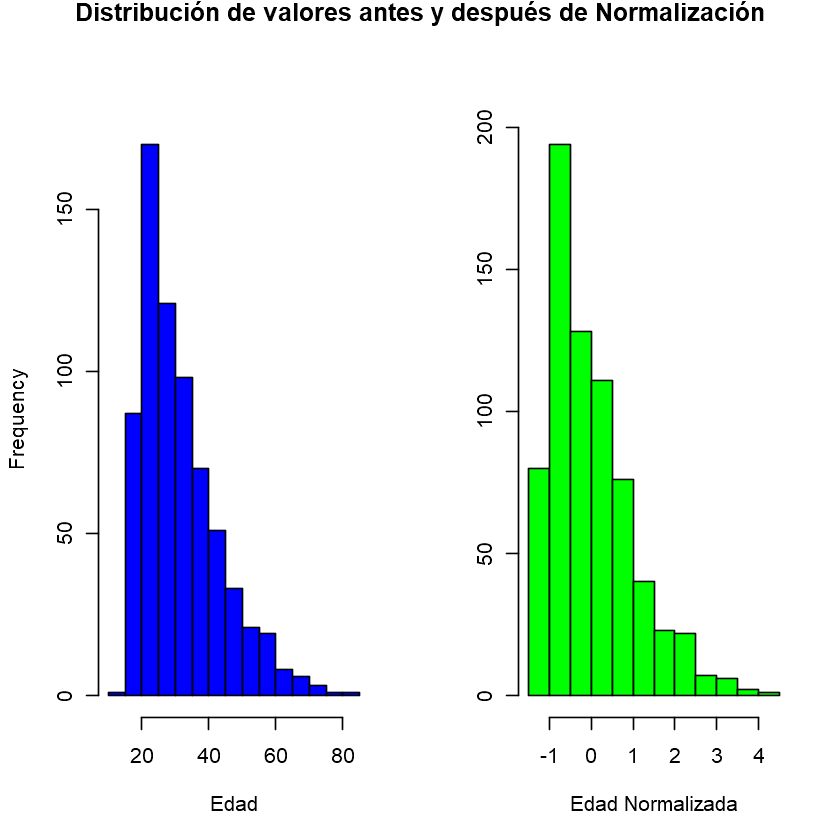

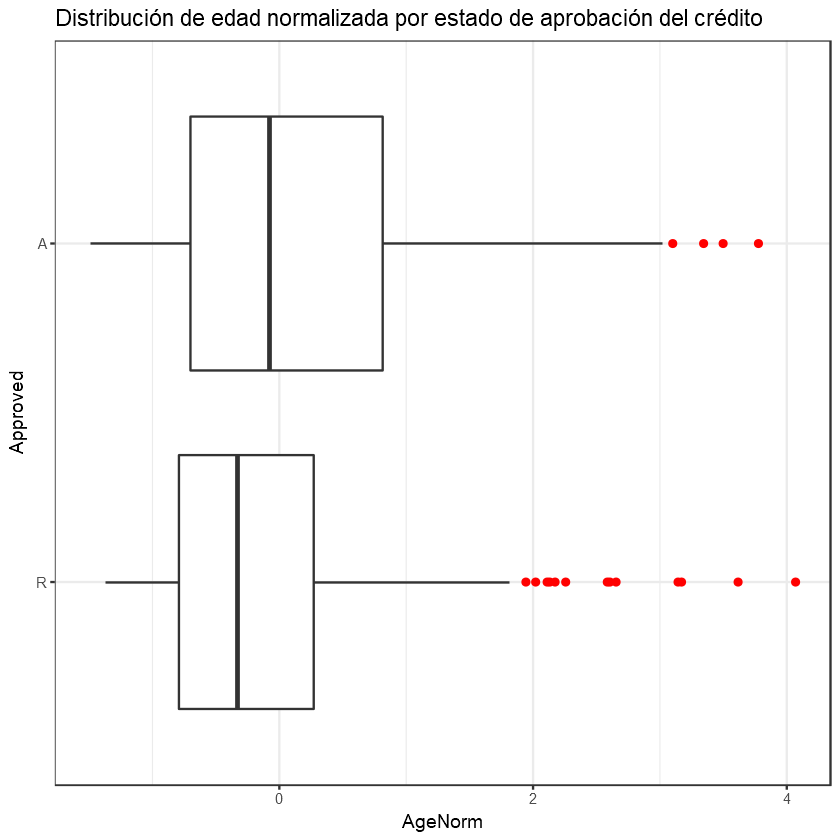

In [249]:
# Se analiza los valores de la distibución de la edad 
par(mfrow=c(1,2), oma=c(0,0,1,0))
hist(Data$Age,main=NULL,xlab="Edad",col="blue")
hist(Data$AgeNorm,main=NULL,xlab="Edad Normalizada",ylab=NULL,col="green")
title("Distribución de valores antes y después de Normalización",outer=T)

# Crea un boxplot
ggplot(Data) + 
  aes(Approved,AgeNorm) + 
  geom_boxplot(outlier.colour="red") +
  theme_bw() +
  coord_flip() +
  labs(title="Distribución de edad normalizada por estado de aprobación del crédito")

null device 
          1

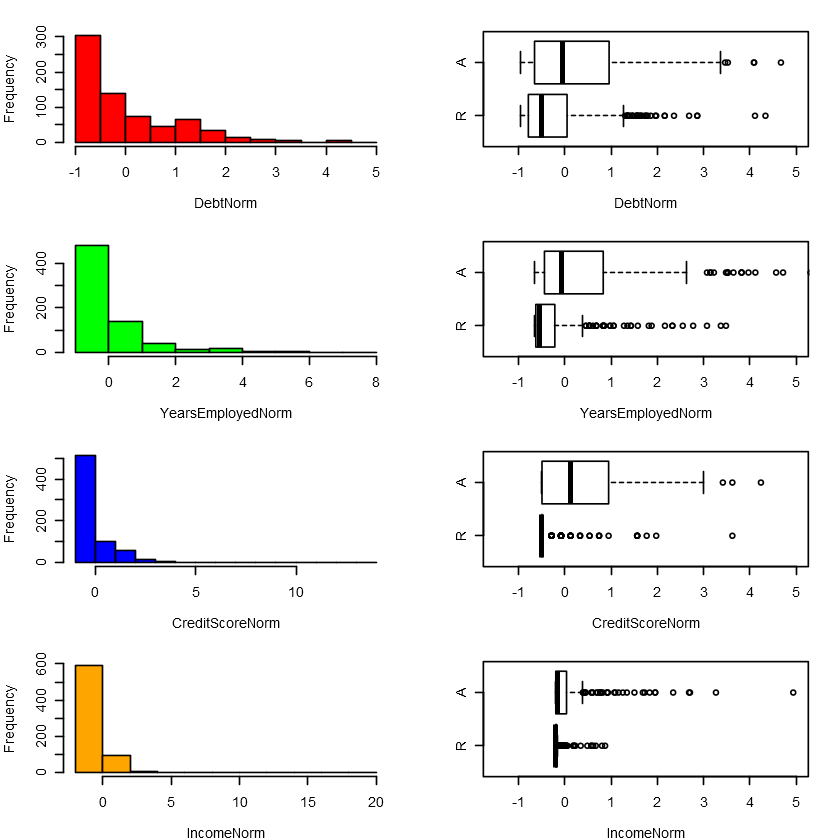

In [250]:
# Normaliza las variables
Temp<- data.frame(scale(Data[,c(3,8,11,15)],center=T,scale=T))
colnames(Temp)<-c("DebtNorm","YearsEmployedNorm","CreditScoreNorm","IncomeNorm")
Data<-cbind(Data,Temp)
rm(Temp)

# Visualiza con los valores normalizados
par(mfrow=c(4,2),mar=c(4,4,2,2))
hist(Data$DebtNorm,main=NULL,xlab="DebtNorm",col="red",ylab="Frequency")
boxplot(DebtNorm~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="DebtNorm")

hist(Data$YearsEmployedNorm,main=NULL,xlab="YearsEmployedNorm",col="green")
boxplot(YearsEmployedNorm~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="YearsEmployedNorm")

hist(Data$CreditScoreNorm,main=NULL,xlab="CreditScoreNorm",col="blue")
boxplot(CreditScoreNorm~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="CreditScoreNorm")

hist(Data$IncomeNorm,main=NULL,xlab="IncomeNorm",col="orange")
boxplot(IncomeNorm~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="IncomeNorm")
dev.off()

null device 
          1

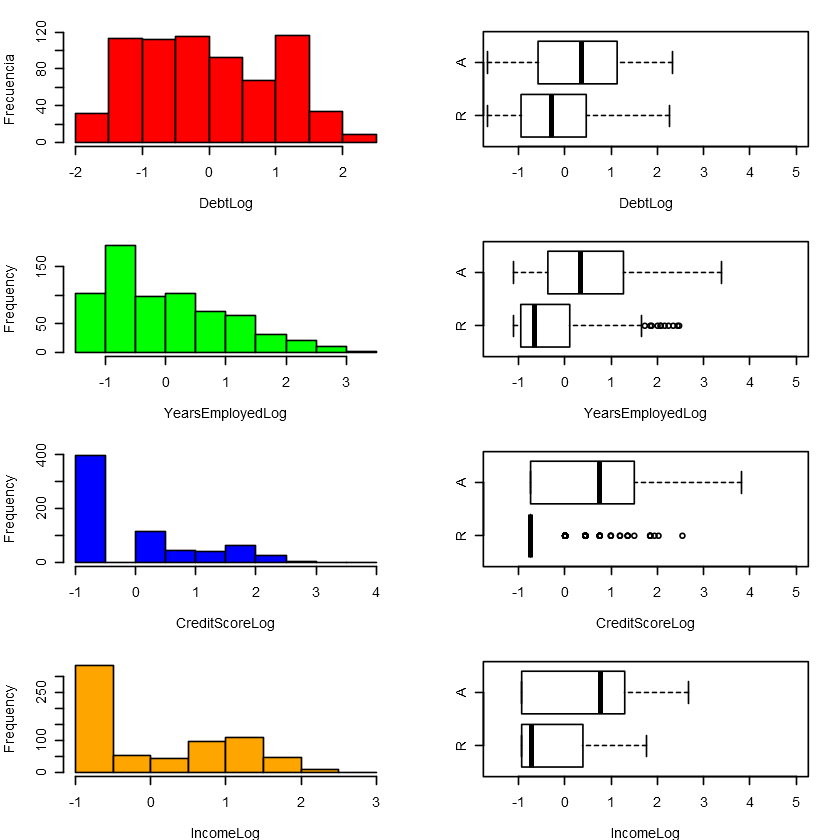

In [251]:
# Centra y transforma por el logaritmo de los datos
Temp<- data.frame(scale(log(Data[,c(3,8,11,15)]+1),center=T))
names(Temp)<-c("DebtLog","YearsEmployedLog","CreditScoreLog","IncomeLog")
Data<-cbind(Data,Temp)
rm(Temp)


# Presenta los datos transformados
par(mfrow=c(4,2),mar=c(4,4,2,2))
hist(Data$DebtLog,main=NULL,xlab="DebtLog",col="red",ylab="Frecuencia")
boxplot(DebtLog~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="DebtLog")

hist(Data$YearsEmployedLog,main=NULL,xlab="YearsEmployedLog",col="green")
boxplot(YearsEmployedLog~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="YearsEmployedLog")

hist(Data$CreditScoreLog,main=NULL,xlab="CreditScoreLog",col="blue")
boxplot(CreditScoreLog~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="CreditScoreLog")

hist(Data$IncomeLog,main=NULL,xlab="IncomeLog",col="orange")
boxplot(IncomeLog~Approved,data=Data,horizontal=T,ylim=c(-1.5,5),xlab="IncomeLog")
dev.off()

In [252]:
# Elimina las columnas transformadas
Data<- Data[,-c(2,3,8,11,15,18:21)]


# Aplicaciones de hombres vs. mujeres 
table(Data$Male,useNA="ifany")


# Identifica las observaciones incompletas 
incomplete<-!complete.cases(Data)
ToImpute<-Data[incomplete,]

# Completa las observaciones con la moda

Data$Married <-ifelse(is.na(Data$Married),"u",Data$Married)
Data$BankCustomer	<-ifelse(is.na(Data$BankCustomer),"g",Data$BankCustomer)
Data$Ethnicity		<-ifelse(is.na(Data$Ethnicity),"v",Data$Ethnicity)
Data$EducationLevel	<-ifelse(is.na(Data$EducationLevel),"c",Data$EducationLevel)
Data$ZipCode		<-ifelse(is.na(Data$ZipCode),"00000",Data$ZipCode)
Data$Male		<-ifelse(is.na(Data$Male),"b",Data$Male)

# Convierte variables categoricas a factores
Data[,1:10]<- lapply(Data[1:10],function(x) factor(x))
Data$Ethnicity<-relevel(Data$Ethnicity,"v")


   M    W <NA> 
 468  210   12 

In [253]:
#Elimina variable Zip Code ya que no aporta al modelo 
Data<- Data[,-c(10)]
summary(Data)

 Male    Married BankCustomer EducationLevel   Ethnicity   PriorDefault
 1:468   l:  2   g :525       c      :146    v      :408   0:329       
 2:210   u:525   gg:  2       q      : 78    h      :138   1:361       
 b: 12   y:163   p :163       w      : 64    bb     : 59               
                              i      : 59    ff     : 57               
                              aa     : 54    j      :  8               
                              ff     : 53    z      :  8               
                              (Other):236    (Other): 12               
 Employed DriversLicense Citizen Approved PriorDefaul   IncomeNorm     
 E :395   f:374          g:625   R:383    D :329      Min.   :-0.1953  
 NE:295   t:316          p:  8   A:307    ND:361      1st Qu.:-0.1953  
                         s: 57                        Median :-0.1943  
                                                      Mean   : 0.0000  
                                                      3rd Qu.:-0

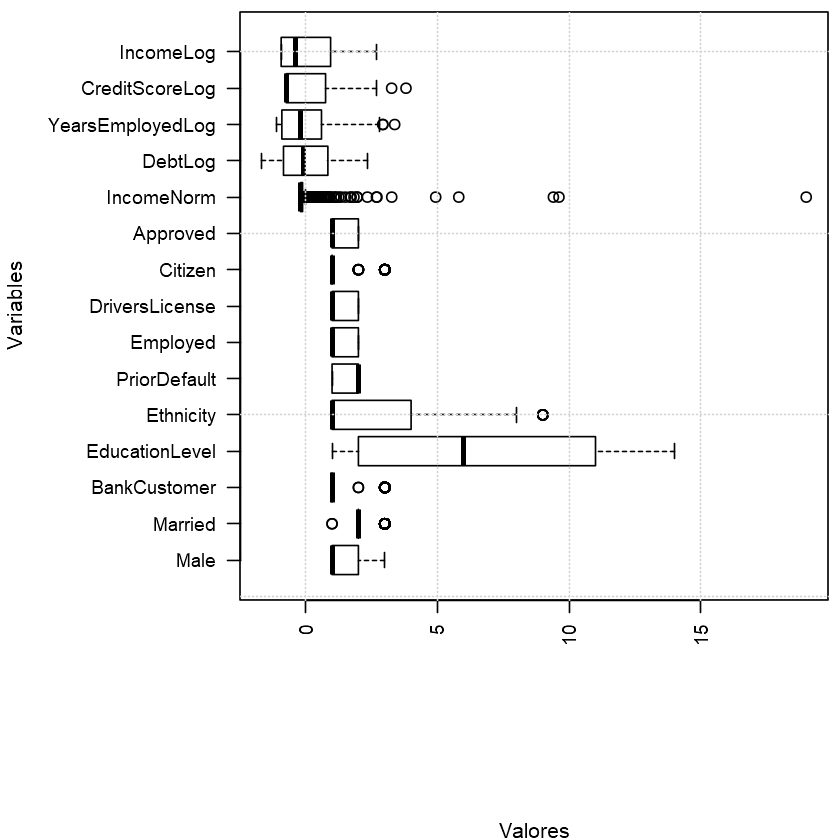

In [254]:
##
## se examina el rango de las variables
##
par(mar = c(10, 10, 0.5, 0.5), mgp = c(9, 1, 0), cex.axis=.9)
plt <- boxplot(Data[,-11], 
               xlab="Valores", 
               ylab="Variables",
               srt = 90,
               horizontal=TRUE,
               las=2)

grid()

# Partición de los datos

Para realizar esta tarea se utiliza la función *createDataPartition* del paquete *caret* que crea una partición aleatoria y proporcional de los conjuntos de entrenamiento y prueba.

Tambien se utiliza el objeto *trctrl* con el método "repeatedcv" para usar crossvalidation en la selección de los datos que usa cada técnica.

In [255]:
##
## Se crean los conjuntos de entrenamiento y prueba
##
set.seed(123)
indexes <- createDataPartition(Data$Approved,
                               times = 1,
                               p = 0.7,
                               list = FALSE)

train.data      <- Data[indexes, ]
test.data       <- Data[-indexes, ]

##
## Se define el método de crossvalidation
##
trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3,
                       summaryFunction=twoClassSummary,
                       classProbs=TRUE,
                       savePredictions = T)

In [256]:
##
## Se confirma la distribución de datos de entrenamiento y prueba
##
print("Distribución de entrenamiento")
round(prop.table(table(train.data$Approved))*100,digits=1)
print("Distribución de prueba")
round(prop.table(table(test.data$Approved))*100,digits=1)


[1] "Distribución de entrenamiento"



   R    A 
55.6 44.4 

[1] "Distribución de prueba"



   R    A 
55.3 44.7 

# MODELOS
----------------
Los modelos a evaluar son los siguientes:
* k-Nearest Neighbors, KNN
* Random Forest, RF
* Boosted Trees, XGB
* Support Vector Machine, SVM

# KNN

In [257]:
###############################################################
## Se revisan los parámetros para el modelo k-Nearest Neighbors 
###############################################################

modelLookup("knn")

model,parameter,label,forReg,forClass,probModel
knn,k,#Neighbors,TRUE,TRUE,TRUE


In [258]:
###############################################################
## Se establecen parámetros para el modelo k-Nearest Neighbors 
###############################################################

trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3,
                       summaryFunction=twoClassSummary,
                       classProbs=TRUE,
                       savePredictions = T)
k = 50 # número de valores aleatorios que tomará k (cantidad de vecinos) 
       # para evaluar el modelo

In [259]:
######################################################
## Se ejecuta el modelo k-Nearest Neighbors 
######################################################

set.seed(123)
knn_fit <- train(Approved ~., data = train.data, method = "knn",
                 trControl=trctrl,
                 preProcess = c("center", "scale"),
                 tuneLength = k)   
knn_fit

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

k-Nearest Neighbors 

484 samples
 15 predictor
  2 classes: 'R', 'A' 

Pre-processing: centered (38), scaled (38) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 436, 436, 436, 435, 435, 436, ... 
Resampling results across tuning parameters:

  k    ROC        Sens       Spec     
    5  0.8704100  0.8586895  0.7650072
    7  0.8803751  0.8636752  0.7679654
    9  0.8836271  0.8834283  0.7710678
   11  0.8908144  0.8970560  0.7616883
   13  0.8964381  0.9070275  0.7663059
   15  0.9040616  0.9082621  0.7618326
   17  0.9103509  0.9095442  0.7631313
   19  0.9126195  0.9145774  0.7723665
   21  0.9136485  0.9195157  0.7727273
   23  0.9141459  0.9207028  0.7773449
   25  0.9150503  0.9207028  0.7787879
   27  0.9163258  0.9219373  0.7958153
   29  0.9173522  0.9256885  0.7911977
   31  0.9196138  0.9219373  0.7989899
   33  0.9192887  0.9194682  0.7926407
   35  0.9204618  0.9194682  0.7943723
   37  0.9215493  0.9194682  0.8020202
   39  0.9224682  0

In [260]:
#############################################################
## Se calcula la matriz de confusión para k-Nearest Neighbors
#############################################################

test_pred_knn <- predict(knn_fit, newdata = test.data)


confusionMatrix(test_pred_knn, test.data$Approved )



Confusion Matrix and Statistics

          Reference
Prediction   R   A
         R 100  20
         A  14  72
                                          
               Accuracy : 0.835           
                 95% CI : (0.7771, 0.8829)
    No Information Rate : 0.5534          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.664           
 Mcnemar's Test P-Value : 0.3912          
                                          
            Sensitivity : 0.8772          
            Specificity : 0.7826          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.8372          
             Prevalence : 0.5534          
         Detection Rate : 0.4854          
   Detection Prevalence : 0.5825          
      Balanced Accuracy : 0.8299          
                                          
       'Positive' Class : R               
                                          

Area under the curve: 0.9234

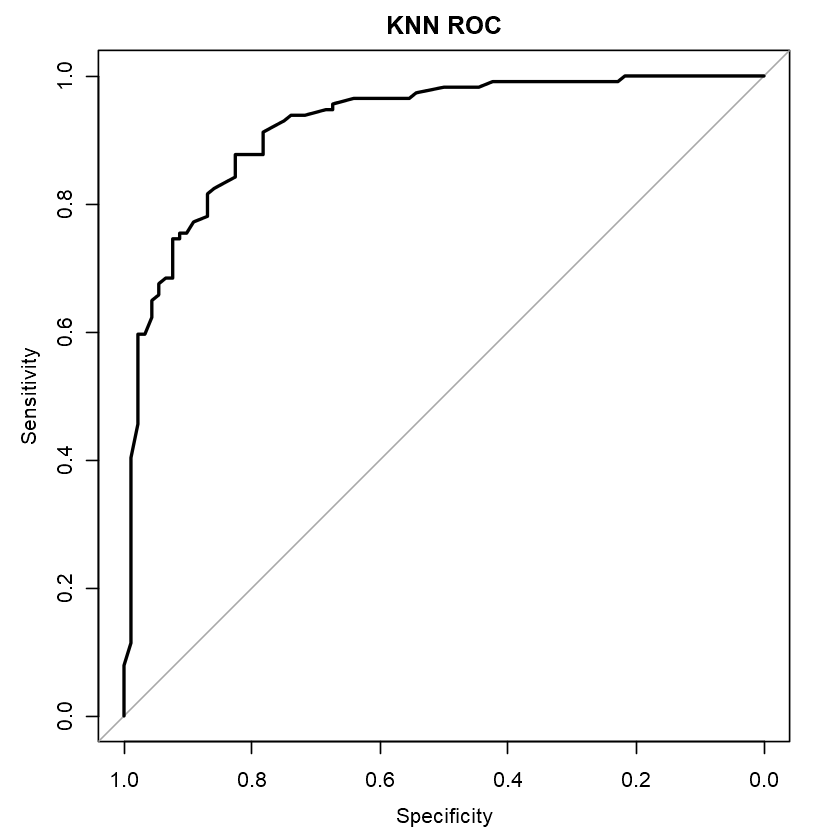

In [261]:
######################################################################
## Se obtiene la curva ROC y valor de AUC para k-Nearest Neighbors
######################################################################

library(pROC)
knn.probs <- predict(knn_fit,test.data,type="prob")
knn.ROC <- roc(predictor=knn.probs$R,
               response=test.data$Approved,
               levels=rev(levels(test.data$Approved)))
knn.ROC$auc
plot(knn.ROC, main="KNN ROC")

# Random Forest


In [262]:
###############################################################
## Se revisan los parámetros para el modelo Random Forest 
###############################################################

modelLookup("rf")

model,parameter,label,forReg,forClass,probModel
rf,mtry,#Randomly Selected Predictors,TRUE,TRUE,TRUE


In [263]:
##########################################################
## Se establecen parámetros para el modelo Random Forest 
##########################################################

trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3,
                       summaryFunction=twoClassSummary,
                       classProbs=TRUE,
                       savePredictions = T)
tune.grid <- expand.grid(mtry = c(1:11))

Random Forest 

484 samples
 15 predictor
  2 classes: 'R', 'A' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 436, 436, 436, 435, 435, 436, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   1    0.9306720  0.9578348  0.6747475
   2    0.9358707  0.8971985  0.8606782
   3    0.9367622  0.8725071  0.8714286
   4    0.9379472  0.8725071  0.8806638
   5    0.9373275  0.8700380  0.8777056
   6    0.9370084  0.8737417  0.8746032
   7    0.9370398  0.8688034  0.8764069
   8    0.9370776  0.8762108  0.8826840
   9    0.9376604  0.8713200  0.8811688
  10    0.9368791  0.8762583  0.8857143
  11    0.9367980  0.8725546  0.8764791

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.

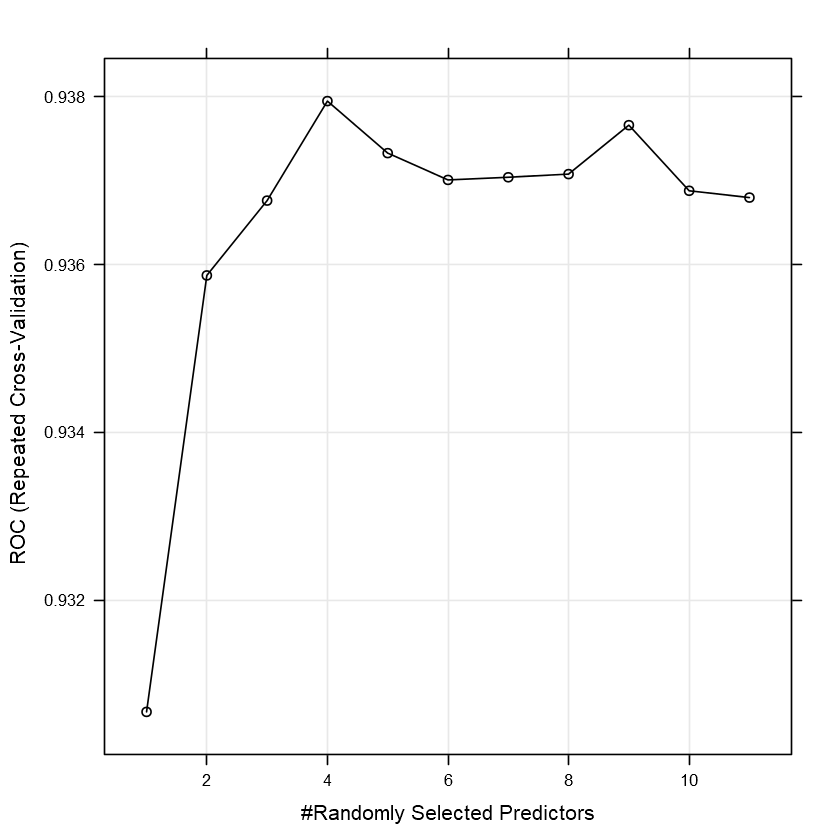

In [264]:
######################################################
## Se ejecuta el modelo Random Forest 
######################################################
set.seed(123)
rf_fit <- train(Approved ~., data = train.data, method = "rf",
                   trControl=trctrl,
                   tuneGrid=tune.grid,
                   metric = "ROC")
rf_fit
trellis.par.set(caretTheme())
plot(rf_fit)

In [265]:
#############################################################
## Se calcula la matriz de confusión para Random Forest
#############################################################

test_pred_rf <- predict(rf_fit, newdata = test.data)
confusionMatrix(test_pred_rf, test.data$Approved )

Confusion Matrix and Statistics

          Reference
Prediction  R  A
         R 90 11
         A 24 81
                                          
               Accuracy : 0.8301          
                 95% CI : (0.7717, 0.8787)
    No Information Rate : 0.5534          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.6609          
 Mcnemar's Test P-Value : 0.04252         
                                          
            Sensitivity : 0.7895          
            Specificity : 0.8804          
         Pos Pred Value : 0.8911          
         Neg Pred Value : 0.7714          
             Prevalence : 0.5534          
         Detection Rate : 0.4369          
   Detection Prevalence : 0.4903          
      Balanced Accuracy : 0.8350          
                                          
       'Positive' Class : R               
                                          

Area under the curve: 0.9159

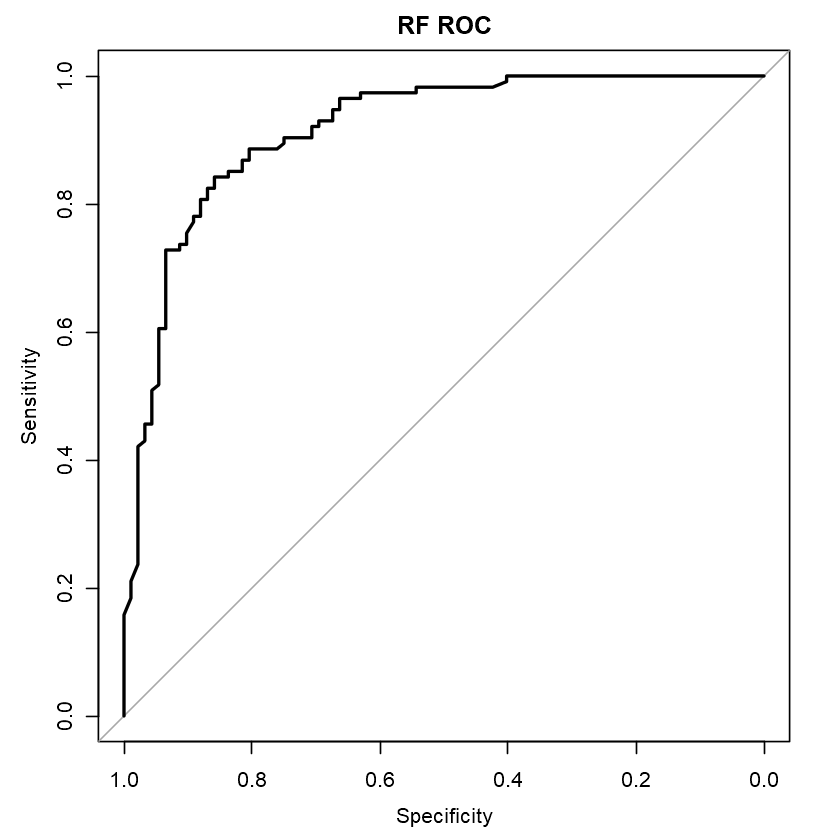

In [266]:
#############################################################
## Se obtiene la curva ROC y valor de AUC para Random Forest
#############################################################

library(pROC)
rf.probs <- predict(rf_fit,test.data,type="prob")
rf.ROC <- roc(predictor=rf.probs$R,
               response=test.data$Approved,
               levels=rev(levels(test.data$Approved)))
rf.ROC$auc
plot(rf.ROC, main="RF ROC")

# Boosted Trees

In [267]:
###############################################################
## Se revisan los parámetros para el modelo Boosted Trees
###############################################################

modelLookup("xgbTree")

model,parameter,label,forReg,forClass,probModel
xgbTree,nrounds,# Boosting Iterations,TRUE,TRUE,TRUE
xgbTree,max_depth,Max Tree Depth,TRUE,TRUE,TRUE
xgbTree,eta,Shrinkage,TRUE,TRUE,TRUE
xgbTree,gamma,Minimum Loss Reduction,TRUE,TRUE,TRUE
xgbTree,colsample_bytree,Subsample Ratio of Columns,TRUE,TRUE,TRUE
xgbTree,min_child_weight,Minimum Sum of Instance Weight,TRUE,TRUE,TRUE
xgbTree,subsample,Subsample Percentage,TRUE,TRUE,TRUE


In [268]:
###############################################################
## Se establecen parámetros para el modelo Boosted Trees 
###############################################################

trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3,
                       summaryFunction=twoClassSummary,
                       classProbs=TRUE,
                       savePredictions = T)
tune.grid <- expand.grid(eta = c(0.1, 0.2, 0.3),
                         nrounds = c(50, 75, 100),
                         max_depth = 6:8,
                         min_child_weight = c(2.0, 2.25, 2.5),
                         colsample_bytree = c(0.3, 0.4, 0.5),
                         gamma = 0,
                         subsample = 1)

eXtreme Gradient Boosting 

484 samples
 15 predictor
  2 classes: 'R', 'A' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 436, 436, 435, 436, 436, 436, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  min_child_weight  nrounds  Accuracy 
  0.1  6          0.3               2.00               50      0.8676871
  0.1  6          0.3               2.00               75      0.8677296
  0.1  6          0.3               2.00              100      0.8656463
  0.1  6          0.3               2.25               50      0.8759779
  0.1  6          0.3               2.25               75      0.8738520
  0.1  6          0.3               2.25              100      0.8780187
  0.1  6          0.3               2.50               50      0.8760629
  0.1  6          0.3               2.50               75      0.8614796
  0.1  6          0.3               2.50              100      0.8655612
  0.1  6   

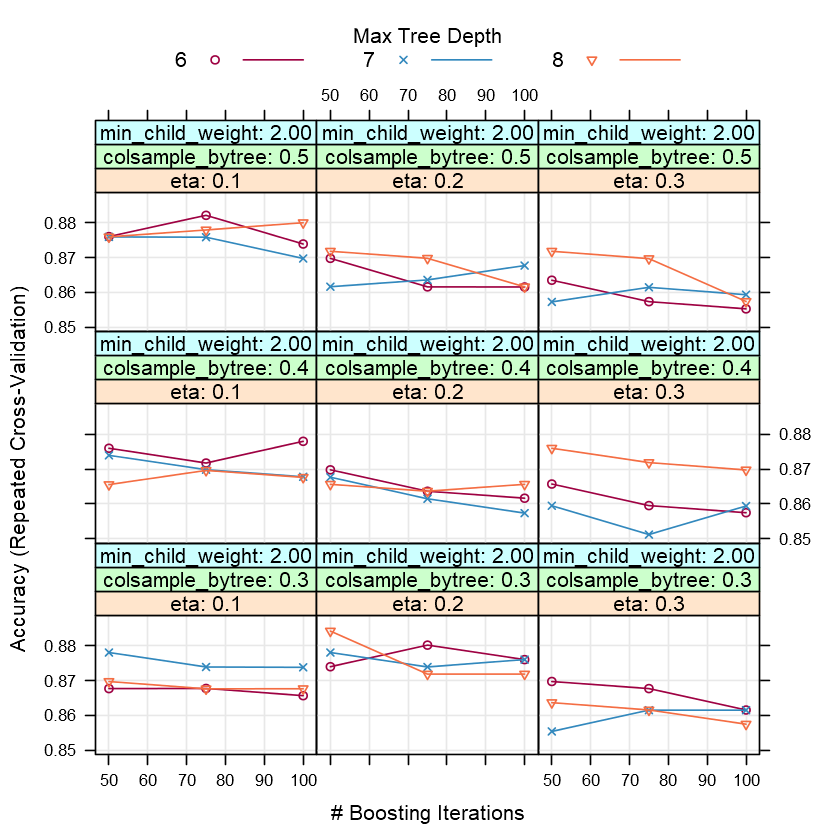

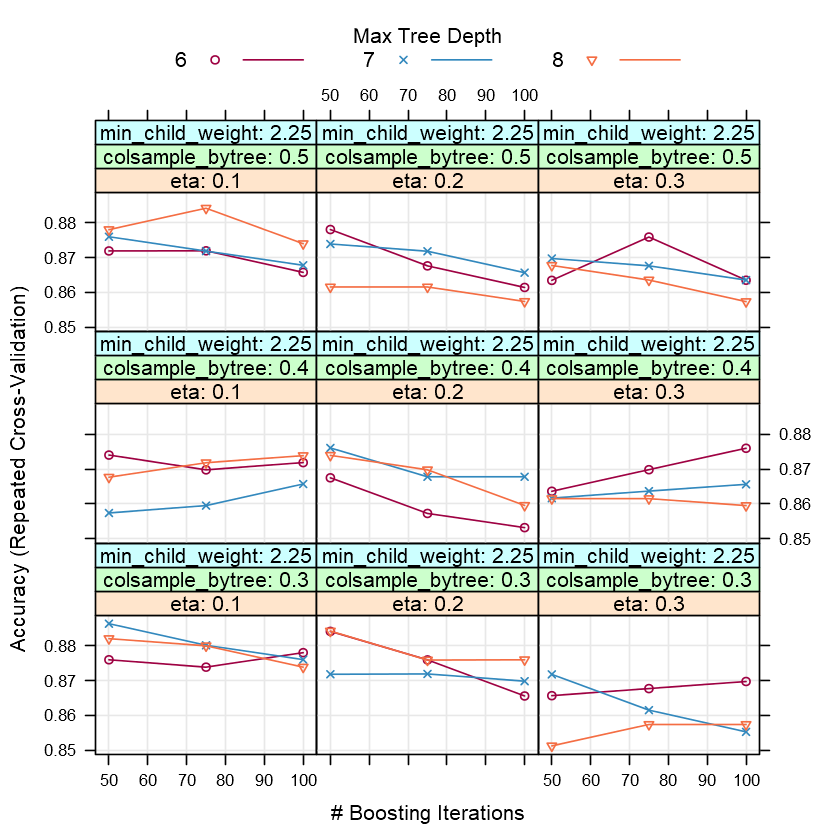

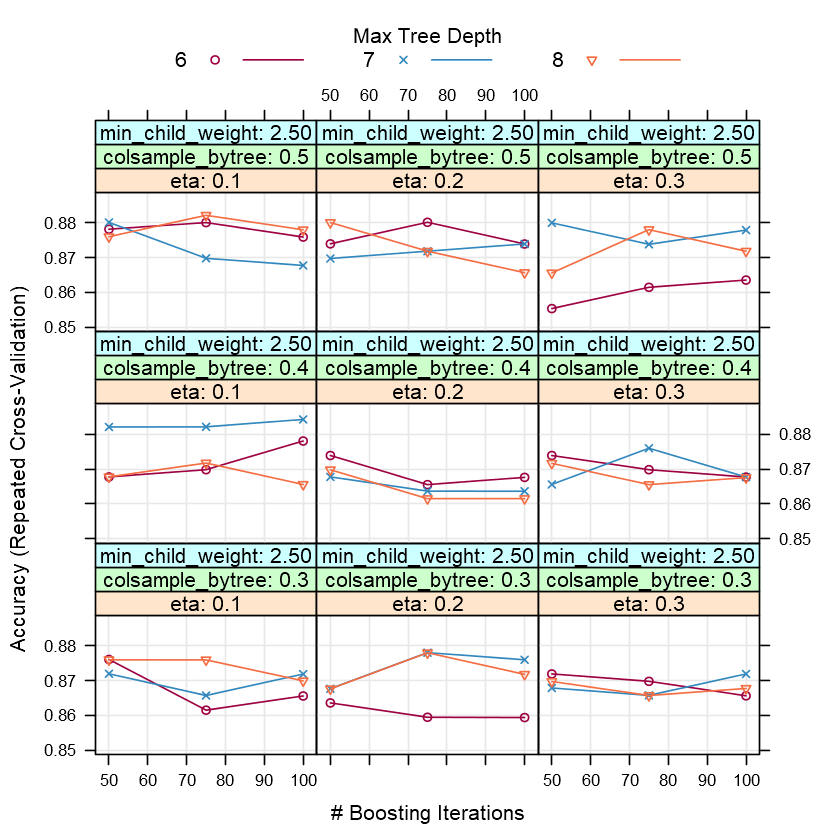

In [269]:
######################################################
## Se ejecuta el modelo Boosted Trees 
######################################################

set.seed(12345)
xgb_fit <- train(Approved ~., data = train.data, method = 'xgbTree',
                 tuneGrid=tune.grid, trControl=train.control)
xgb_fit
plot(xgb_fit)


In [270]:
#############################################################
## Se calcula la matriz de confusión para Boosted Trees
#############################################################

test_pred_xgb <- predict(xgb_fit, newdata = test.data)
confusionMatrix(test_pred_xgb, test.data$Approved )

Confusion Matrix and Statistics

          Reference
Prediction  R  A
         R 95 16
         A 19 76
                                          
               Accuracy : 0.8301          
                 95% CI : (0.7717, 0.8787)
    No Information Rate : 0.5534          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6574          
 Mcnemar's Test P-Value : 0.7353          
                                          
            Sensitivity : 0.8333          
            Specificity : 0.8261          
         Pos Pred Value : 0.8559          
         Neg Pred Value : 0.8000          
             Prevalence : 0.5534          
         Detection Rate : 0.4612          
   Detection Prevalence : 0.5388          
      Balanced Accuracy : 0.8297          
                                          
       'Positive' Class : R               
                                          

Area under the curve: 0.918

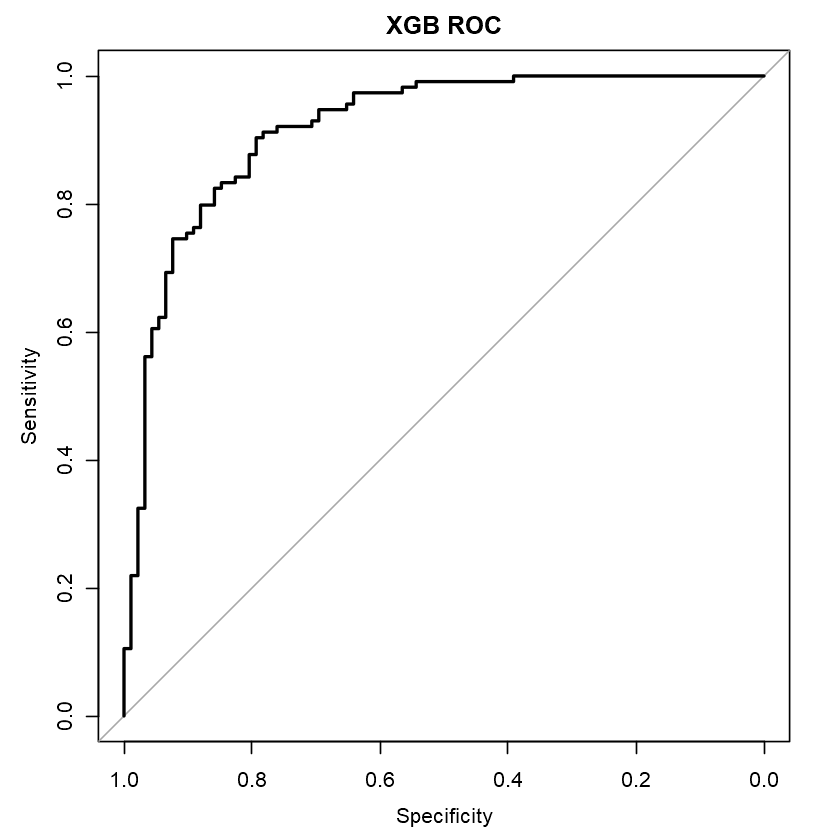

In [271]:
#############################################################
## Se obtiene la curva ROC y valor de AUC para Boosted Trees
#############################################################

library(pROC)
xgb.probs <- predict(xgb_fit,test.data,type="prob")
xgb.ROC <- roc(predictor=xgb.probs$R,
               response=test.data$Approved,
               levels=rev(levels(test.data$Approved)))
xgb.ROC$auc
plot(xgb.ROC, main="XGB ROC")

# Support Vector Machine

In [272]:
#####################################################################
## Se revisan los parámetros para el modelo Support Vector Machine
#####################################################################

modelLookup("svmLinear")


model,parameter,label,forReg,forClass,probModel
svmLinear,C,Cost,TRUE,TRUE,TRUE


In [273]:
####################################################################
## Se establecen parámetros para el modelo Support Vector Machine 
####################################################################

trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3,
                       summaryFunction=twoClassSummary,
                       classProbs=TRUE,
                       savePredictions = T)
grid <- expand.grid(C = c(0,0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,5))

In [274]:
######################################################
## Se ejecuta el modelo Support Vector Machine
######################################################

set.seed(12345)
svm_fit<-svm(Approved ~., data = train.data,
               method = "svmLinear",
               trControl=trctrl,
               preProcess = c("center", "scale"),
               probability = TRUE,
               tuneGrid = grid)
svm_fit


Call:
svm(formula = Approved ~ ., data = train.data, method = "svmLinear", 
    trControl = trctrl, preProcess = c("center", "scale"), probability = TRUE, 
    tuneGrid = grid)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.02564103 

Number of Support Vectors:  210


In [275]:
#####################################################################
## Se calcula la matriz de confusión para Support Vector Machine
#####################################################################

test_pred_svm <- predict(svm_fit, newdata = test.data)
confusionMatrix(test_pred_svm, test.data$Approved )

Confusion Matrix and Statistics

          Reference
Prediction  R  A
         R 85  8
         A 29 84
                                         
               Accuracy : 0.8204         
                 95% CI : (0.761, 0.8703)
    No Information Rate : 0.5534         
    P-Value [Acc > NIR] : 5.422e-16      
                                         
                  Kappa : 0.6445         
 Mcnemar's Test P-Value : 0.001009       
                                         
            Sensitivity : 0.7456         
            Specificity : 0.9130         
         Pos Pred Value : 0.9140         
         Neg Pred Value : 0.7434         
             Prevalence : 0.5534         
         Detection Rate : 0.4126         
   Detection Prevalence : 0.4515         
      Balanced Accuracy : 0.8293         
                                         
       'Positive' Class : R              
                                         

An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.9202899


Slot "alpha.values":
list()


[1] 0.9202899

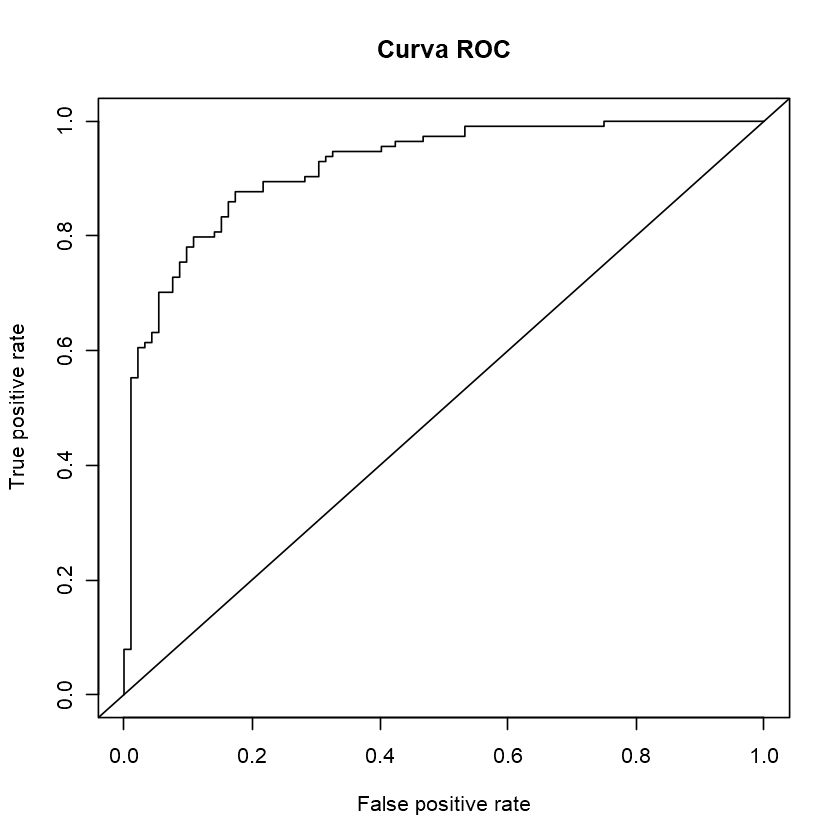

In [276]:
########################################################################
## Se obtiene la curva ROC y valor de AUC para Support Vector Machine
########################################################################

library(ROCR) 
prediction <- predict(svm_fit, test.data, decision.values = TRUE, 
                        probability = TRUE) 
probs <-  attr(prediction, "probabilities")[,2] 
pred <- prediction(probs,test.data$Approved) 
perf <- performance(pred, measure = "auc")
perf

roc_ROCR <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(roc_ROCR, main = "Curva ROC", colorize = F)
abline(a = 0, b = 1)
auc_ROCR <- performance(pred, measure = "auc")
auc_ROCR <- auc_ROCR@y.values[[1]]
auc_ROCR

# Comparación entre modelos

En esta sección se presentan las principales medidas de desempeño halladas en evaluación de los modelos con sus hiperparámetros optimizados y se comparan los resultados obtenidos de acuerdo a cada una de las métricas. 

A continuación se presenta una tabla resumen con los principales resultados obtenidos en los modelos realizados: 

Comparación Resultados | 
--- | --- | ---
*Método* | `Accuracy`| `Kappa`|`Sensitivity`|`Specificity`|`AUC`
KNN | 0,835 | 0,664 | 0,8772 | 0,7826 | 0,9233 
RF	|0,8301 | 0,6609 | 0,7895 | 0,8804 | 0,9159
xgboost | 0,8301 | 0,6574 | 0,8333 | 0,8261 | 0,9180
SVM | 0,8204 | 0,6445 | 0,7456 | 0,9130 | 0,9203	


### Precisión (Accuracy) 
La medida de precisión nos indica la cantidad de predicciones correctas sobre el número total de predicciones, es decir la proporción de aciertos en la predicción. En este sentido el modelo con mayor valor es KNN, con un valor de 0,835. 

### Kappa
Es una medida de concordancia o consistencia en la clasificación, cuando más cercano a 1 es el valor mayor será la concordancia. Nuevamente el modelo de KNN es el que tiene mayor valor. 

### Sensibilidad (Sensitivity) 
La sensibilidad se mide con los valores verdaderos predichos de manera correcta entre el total de valores positivos reales, sería una medida de que tan bien está clasificando nuestra variable objetivo, en este caso aquellos clientes que se les rechaza la aplicación de la tarjeta de crédito. Aquí también obtiene el mejor valor el modelo KNN.

### Especificidad (Specificity) 
La especificidad se refiere a la capacidad del modelo de excluir correctamente los casos negativos. En este caso sería que clasifique correctamente aquellos cliente que si se les aprobó la tarjeta. El este caso el modelo con mayor puntaje es Support Vector Machine. 

### Área bajo la curva (AUC) 
Esta medida refleja  la tasa de verdaderos positivos respecto a la tasa de falsos positivos, los valores cercanos a 1 son mejores. En este el modelo KNN vuelve a ser el de mejor puntaje.  

Por el análisis anterior, y fundamentalmente, porque entregar una tarjeta de crédito a una persona que no corresponda genera un riesgo para una empresa financiera, por lo tanto se debe ponderar el clasificador que mejor clasifique aquellos clientes a los que no se debe aprobar una tarjeta de crédito.

Por lo tanto el modelo seleccionado es el de Vecinos más cercanos (KNN).





